<a href="https://colab.research.google.com/github/Taophycc/NVIDIA-iQuHACK-2026/blob/main/qaoa_labs_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/Taophycc/NVIDIA-iQuHACK-2026.git
%cd NVIDIA-iQuHACK-2026
!ls

Cloning into 'NVIDIA-iQuHACK-2026'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 334 (delta 78), reused 70 (delta 70), pack-reused 247 (from 1)
Receiving objects: 100% (334/334), 7.78 MiB | 15.69 MiB/s, done.
Resolving deltas: 100% (168/168), done.
/content/NVIDIA-iQuHACK-2026
GPU_PIC_Brev.pdf	  NVIDIA-presentation-slides-MIT-IQuHack.pdf
images			  README.md
LABS-challenge-Phase1.md  team-submissions
LABS-challenge-Phase2.md  tutorial_notebook


In [3]:
!pip install cuda-quantum-cu12 --extra-index-url https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 MB 103.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 279.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 134.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.5/122.5 MB 9.9 MB/s eta 0:00:00


In [4]:
import numpy as np

def labs_energy(s):
  N = len(s)
  energy = 0

  for k in range(1, N):
    autocorrelation = 0
    for i in range(N-k):
      autocorrelation += s[i] * s[i+k]
    energy += autocorrelation**2
  return energy
n_qubits = 25
test_seq = np.random.choice([-1, 1], size=n_qubits)

print(f"Testing Sequence (N={n_qubits}):\n{test_seq}")
print(f"\nCalculated Energy: {labs_energy(test_seq)}")

Testing Sequence (N=25):
[-1 -1 -1  1  1 -1  1  1  1  1 -1  1 -1  1  1  1 -1  1 -1  1 -1  1 -1 -1
  1]

Calculated Energy: 224


🚀 Initializing Proper LABS QAOA for N=25...
Starting GPU-Accelerated Optimization (N=25)...
--- Run 1/3 ---
Run 1 Energy: 299.9994
--- Run 2/3 ---
Run 2 Energy: 299.9992
--- Run 3/3 ---
Run 3 Energy: 299.9996

Sampling the circuit with optimized parameters...

✅ PROPER CODE COMPLETE
Optimized Energy (Expected): 299.9992
Verified Energy (Actual): 288
Best Bitstring: 1001011000011010111111111
The Signal: [-1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

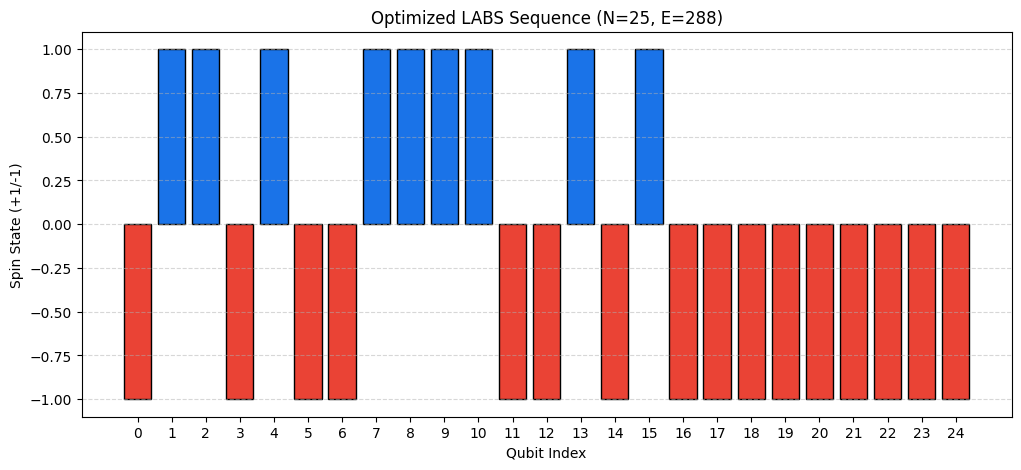

In [1]:
import cudaq
from cudaq import spin
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 1. SETUP & CONFIGURATION
N = 25              # Sequence length (Number of qubits)
STEPS = 1           # QAOA layers (p)
NUM_RUNS = 3        # Multi-start optimization runs
np.random.seed(42)  # For reproducibility

print(f"🚀 Initializing Proper LABS QAOA for N={N}...")

# 2. HAMILTONIAN GENERATION (The Physics)
def get_labs_hamiltonian(n_val):
    """Maps the squared autocorrelation function to a 4-qubit Spin Operator."""
    ham = 0 * spin.z(0)
    for k in range(1, n_val):
        for i in range(n_val - k):
            for j in range(n_val - k):
                # Mapping s_i * s_{i+k} * s_j * s_{j+k}
                ham += spin.z(i) * spin.z(i+k) * spin.z(j) * spin.z(j+k)
    return ham

ham_obj = get_labs_hamiltonian(N)

# 3. QUANTUM KERNEL (The Circuit)
def build_qaoa_kernel(n_qubits, p_steps):
    """Constructs the QAOA circuit using make_kernel for stability."""
    kernel, params = cudaq.make_kernel(list)
    q = kernel.qalloc(n_qubits)

    # Step 1: Superposition (Start with all possible sequences)
    kernel.h(q)

    # Step 2: Alternating Layers
    for step in range(p_steps):
        # COST LAYER: Approximate phase rotation based on interactions
        for i in range(n_qubits - 1):
            kernel.cx(q[i], q[i+1])
            kernel.rz(params[step], q[i+1])
            kernel.cx(q[i], q[i+1])

        # MIXER LAYER: Allows tunneling through energy barriers
        for i in range(n_qubits):
            kernel.rx(params[step + p_steps], q[i])

    return kernel

qaoa_kernel = build_qaoa_kernel(N, STEPS)

# 4. OBJECTIVE FUNCTION
def objective(angles):
    """Returns the expectation value (Energy) from the GPU simulator."""
    result = cudaq.observe(qaoa_kernel, ham_obj, angles)
    return result.expectation()

# 5. MULTI-START OPTIMIZATION
print(f"Starting GPU-Accelerated Optimization (N={N})...")
best_final_energy = float('inf')
best_params = None

for run in range(NUM_RUNS):
    print(f"--- Run {run+1}/{NUM_RUNS} ---")
    initial_guess = np.random.uniform(-0.5, 0.5, 2 * STEPS)

    current_res = minimize(
        objective,
        x0=initial_guess,
        method='COBYLA',
        options={'maxiter': 50},
        tol=1e-3
    )
    print(f"Run {run+1} Energy: {current_res.fun:.4f}")

    if current_res.fun < best_final_energy:
        best_final_energy = current_res.fun
        best_params = current_res.x

class OptimizationResult:
    def __init__(self, fun, x):
        self.fun, self.x = fun, x

res = OptimizationResult(best_final_energy, best_params)

# 6. EXTRACTION (Sampling the Bitstring)
print("\nSampling the circuit with optimized parameters...")
counts = cudaq.sample(qaoa_kernel, res.x.tolist())

best_bitstring = ""
max_count = -1

for bitstring, count in counts.items():
    if count > max_count:
        max_count = count
        best_bitstring = bitstring

final_sequence = [1 if bit == '0' else -1 for bit in best_bitstring]

# 7. CLASSICAL VERIFICATION
def final_verify(s):
    L = len(s)
    e = 0
    for k in range(1, L):
        ac = sum(s[i] * s[i+k] for i in range(L-k))
        e += ac**2
    return e

ver_energy = final_verify(final_sequence)

print(f"\n✅ PROPER CODE COMPLETE")
print(f"Optimized Energy (Expected): {res.fun:.4f}")
print(f"Verified Energy (Actual): {ver_energy}")
print(f"Best Bitstring: {best_bitstring}")

# 8. VISUALIZATION
plt.figure(figsize=(12, 5))
colors = ['#1a73e8' if x == 1 else '#ea4335' for x in final_sequence]
plt.bar(range(N), final_sequence, color=colors, edgecolor='black')
plt.title(f"Optimized LABS Sequence (N={N}, E={ver_energy})")
plt.xlabel("Qubit Index")
plt.ylabel("Spin State (+1/-1)")
plt.xticks(range(N))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()